In [1]:
import numpy as np  
import scipy.stats
import pandas as pd
import seaborn as sns
import random
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
 
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans,DBSCAN,SpectralClustering,AgglomerativeClustering,Birch
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn import svm

## Generate Random 2D Data : with labels

,index,x,y,label,Constrained_label
0,0,-1.503886,1.212158,0,0
1,1,1.307350,-5.645378,0,2
2,2,-2.779345,3.005939,0,0
3,3,1.474890,7.855131,0,0
4,4,0.222325,1.685709,0,0


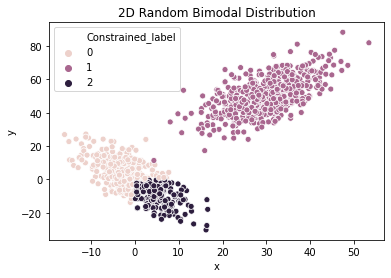

In [2]:
n = 500
mean_1 = [0,0]
cov_1 = [[10,-50],
        [-50, 100]] 
# x,y = np.random.multivariate_normal(mean_1,cov_1,n).T

mean_2 = [30,50]
cov_2 = [[10,70],
        [70,100]] 
# x_2,y_2 = np.random.multivariate_normal(mean_2,cov_2,n).T
random.seed(123)
x,y = np.append(np.random.multivariate_normal(mean_1,cov_1,n).T,
                 np.random.multivariate_normal(mean_2,cov_2,n).T,
                axis=1
                )

data = pd.DataFrame({'x':x,'y':y})
del x,y
data['label'] = np.append(np.repeat(0,n),np.repeat(1,n),axis = 0)
data['Constrained_label'] = [2 if (xx>0 and yy < 0) else zz for (xx,yy,zz) in zip(data.x,data.y,data.label)]
data.reset_index(inplace=True)
sns.scatterplot(data.x,data.y,hue = data.Constrained_label).set_title("2D Random Bimodal Distribution")
data.head()

,index,x,y,label,Constrained_label
0,0,3.447843,12.927963,0,0
1,1,-7.329748,-8.434758,0,0
2,2,2.619394,-2.679352,0,2
3,3,0.956908,2.052912,0,0
4,4,5.457089,5.310238,0,0


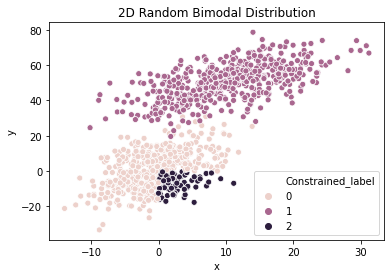

In [3]:
n = 500
mean_1 = [0, 0]
cov_1 = [[20, 20], [20, 100]]
# x,y = np.random.multivariate_normal(mean_1,cov_1,n).T

mean_2 = [10, 50]
cov_2 = [[10, 70], [70, 100]]
# x_2,y_2 = np.random.multivariate_normal(mean_2,cov_2,n).T
random.seed(123)
x, y = np.append(
    np.random.multivariate_normal(mean_1, cov_1, n).T,
    np.random.multivariate_normal(mean_2, cov_2, n).T,
    axis=1,
)

data_2 = pd.DataFrame({'x':x,'y':y})
del x,y
data_2['label'] = np.append(np.repeat(0,n),np.repeat(1,n),axis = 0)
data_2['Constrained_label'] = [2 if (xx>0 and yy < 0) else zz for (xx,yy,zz) in zip(data_2.x,data_2.y,data_2.label)]
data_2.reset_index(inplace=True)
sns.scatterplot(data_2.x,data_2.y,hue = data_2.Constrained_label).set_title("2D Random Bimodal Distribution")
data_2.head()


In [4]:
print("Unique Lables in data :",data.Constrained_label.unique())
scale = StandardScaler()
stand_data = pd.DataFrame(scale.fit_transform(data.iloc[:,0:2]),columns = ['x','y'])
stand_data['Constrained_label'] = data.Constrained_label
data.iloc[:,1:3].to_csv("./data.txt",header = False,index = False,sep = "\t")
data.head()

Unique Lables in data : [0 2 1]


,index,x,y,label,Constrained_label
0,0,-1.503886,1.212158,0,0
1,1,1.307350,-5.645378,0,2
2,2,-2.779345,3.005939,0,0
3,3,1.474890,7.855131,0,0
4,4,0.222325,1.685709,0,0


In [20]:
class makeConstraintFileCsv():

    def __init__(self,data,cluster_number):
        self.data = data
        self.cluster_number = cluster_number
        
        assert isinstance(self.data,pd.DataFrame)
        assert isinstance(self.cluster_number, int)
        # print('AllGood')

    def make_file(self,file_name):
        from itertools import combinations,product,chain
        
        self.data = self.data
        # const_data = self.data[(self.data.x > 0) & (self.data.y<0)]
        ml_list = []
        cl_list = []
        for lbl in np.unique(self.data.Constrained_label):
            ml_list = list(chain(ml_list,
                                [(i,j,1) for (i,j) in list(combinations(self.data.index[self.data.Constrained_label == lbl], 2))]
                                ))

        for (x,y) in list(combinations(np.unique(self.data.Constrained_label),2)):
            cl_list = list(chain(cl_list,
                                [(i,j,-1) for (i,j) in list(product(self.data.index[self.data.Constrained_label == x], self.data.index[self.data.Constrained_label == y]))]
                                ))
        total_list  = list(chain(ml_list,cl_list))
        print(len(total_list),len(total_list)*0.01)
        random_list = random.sample(range(0, len(total_list)), int(len(total_list)*0.01))

        f=open(file_name,'w')
        for ele in [total_list[i] for i in random_list]:
            for element in ele:
                f.write(str(element)+'\t')
            f.write('\n')
        f.close()

x = makeConstraintFileCsv(data,3)
x.make_file('constraints_file_0.01.csv')

# data['Constrained_label'] = [2 if (xx>0 and yy < 0) else zz for (xx,yy,zz) in zip(data.x,data.y,data.label)]

499500 4995.0


Wall time: 330 ms


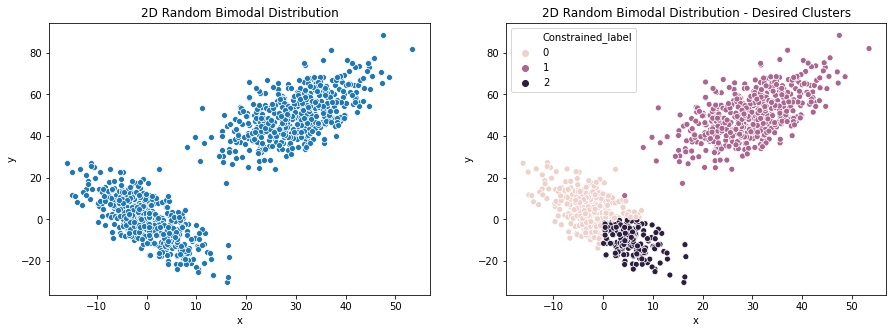

In [8]:
%%time 
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.scatterplot(data.x,data.y).set_title("2D Random Bimodal Distribution")
plt.subplot(122)
sns.scatterplot(data.x,data.y,hue=data.Constrained_label).set_title("2D Random Bimodal Distribution - Desired Clusters")
plt.savefig("./ExpectedOutput.png")

In [35]:
!"C:/Users/z0046rfx/OneDrive - Siemens Healthineers/GitHub/customKmeans/.venv/Scripts/python.exe" "c:/Users/z0046rfx/OneDrive - Siemens Healthineers/GitHub/customKmeans/copkmeans.py"

Data File read successfully!
Constraints File read successfully!
1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1

In [36]:
result = pd.read_csv("./output.txt",header=None)
result.columns = ['col']
# print(result.columns)
print(np.unique(result.col))
# print(len(pd.Series(result['2'])))
x = list(pd.Series(result['col']))
stand_data['new'] = x
stand_data.head()

[0 1 2]


,x,y,Constrained_label,new
0,-1.730320,-1.006112,0,1
1,-1.726856,-0.833322,2,0
2,-1.723391,-1.084507,0,1
3,-1.719927,-0.823024,0,1
4,-1.716463,-0.900012,0,1


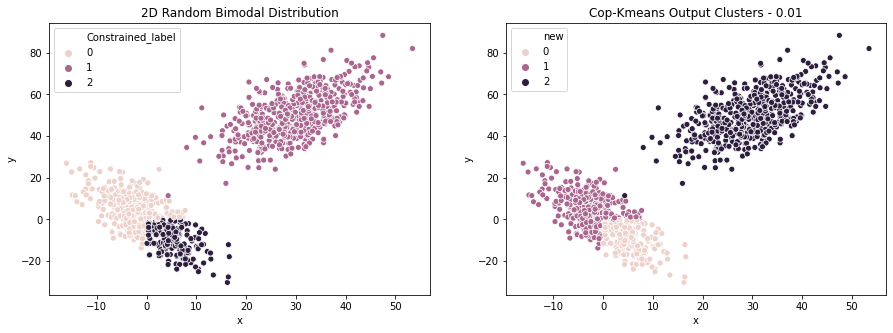

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.scatterplot(data.x,data.y,hue=data.Constrained_label).set_title("2D Random Bimodal Distribution")
plt.subplot(122)
# sns.scatterplot(data.x,data.y,hue=data.Constrained_label).set_title("2D Random Bimodal Distribution - Desired Clusters")
# plt.savefig("./ExpectedOutput.png")


sns.scatterplot(data.x,data.y,hue=stand_data.new).set_title("Cop-Kmeans Output Clusters - 0.01")  
plt.savefig("./images/COP-kmeans_Output_0.01.png")

In [38]:
normalized_mutual_info_score(stand_data.Constrained_label, stand_data.new)

0.9936394322439909